In [1]:
import numpy as np
import numpyro as npyro
import matplotlib.pyplot as plt
import pandas as pd
import numpyro.distributions as dist
import jax
from numpyro.infer import MCMC, NUTS 

### Load data

In [2]:
data = pd.read_csv("weights_baby.csv")

In [3]:
np.unique(data.ID.values)

array([  33,   55,   63,   70,   92,  103,  116,  150,  167,  170,  185,
        252,  293,  309,  432,  433,  475,  565,  747,  788,  871,  946,
       1030, 1184, 1207, 1297, 1306, 1360, 1371, 1374, 1405, 1503, 1629,
       1639, 1740, 1789, 1815, 1915, 1973, 2045, 2087, 2187, 2197, 2199,
       2213, 2233, 2237, 2249, 2283, 2328, 2371, 2394, 2461, 2499, 2507,
       2525, 2532, 2533, 2583, 2643, 2718, 2774, 2798, 2812, 2854, 2870,
       2889, 2895, 2913, 2953, 2973, 2991, 3038, 3069, 3078, 3135, 3144,
       3180, 3216, 3257, 3264, 3332, 3358, 3438, 3491, 3504, 3508, 3512,
       3524, 3555, 3577, 3665, 3685, 3868, 3904, 3921, 3927, 3970, 3987,
       3997])

Text(0.5, 0, '$\\sigma [Kg]$')

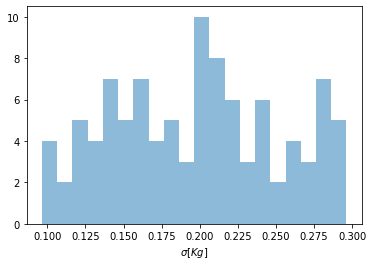

In [14]:
plt.hist(data["sigma"].values, bins=20, alpha=0.5, density=1)
plt.xlabel(r"$\sigma [Kg]$")

In [11]:
data.keys()

Index(['index', 'ID', 'day', 'obs', 'w', 'q', 'sigma'], dtype='object')

Text(0.5, 0, '$W_1 [Kg]$')

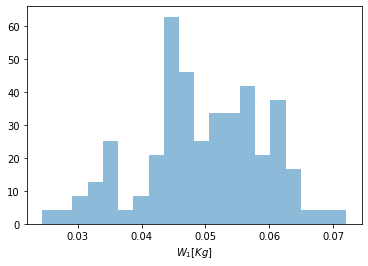

In [13]:
plt.hist(data["w"].values, bins=20, alpha=0.5, density=1)
plt.xlabel(r"$W_1 [Kg]$")

Values are repeated 

(array([ 6.,  9., 12., 11.,  8., 18.,  9.,  8.,  7., 12.]),
 array([0.09647216, 0.11645502, 0.13643788, 0.15642073, 0.17640359,
        0.19638645, 0.21636931, 0.23635217, 0.25633502, 0.27631788,
        0.29630074]),
 <BarContainer object of 10 artists>)

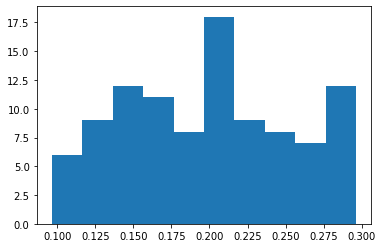

In [19]:
plt.hist(np.unique(data.sigma.values))

### Associate the ID to an incremental number

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
np.unique(data.ID.values)

array([  33,   55,   63,   70,   92,  103,  116,  150,  167,  170,  185,
        252,  293,  309,  432,  433,  475,  565,  747,  788,  871,  946,
       1030, 1184, 1207, 1297, 1306, 1360, 1371, 1374, 1405, 1503, 1629,
       1639, 1740, 1789, 1815, 1915, 1973, 2045, 2087, 2187, 2197, 2199,
       2213, 2233, 2237, 2249, 2283, 2328, 2371, 2394, 2461, 2499, 2507,
       2525, 2532, 2533, 2583, 2643, 2718, 2774, 2798, 2812, 2854, 2870,
       2889, 2895, 2913, 2953, 2973, 2991, 3038, 3069, 3078, 3135, 3144,
       3180, 3216, 3257, 3264, 3332, 3358, 3438, 3491, 3504, 3508, 3512,
       3524, 3555, 3577, 3665, 3685, 3868, 3904, 3921, 3927, 3970, 3987,
       3997])

In [22]:
le = LabelEncoder()

In [23]:
data["myIDs"]=le.fit_transform(data.ID.values)

In [24]:
max_sig = data[data.index==data.sigma.idxmax()]["myIDs"].values[0]
min_sig = data[data.index==data.sigma.idxmin()]["myIDs"].values[0]

In [25]:
num_babies = len(np.unique(data.myIDs.values))

### Create the model

In [26]:
def model(idx, x, y=None):
    
    w_mu = npyro.sample("w_mu", dist.Uniform(0., 1.))
    w_scale = npyro.sample("w_scale", dist.Uniform(4., 10.))
    q_mu = npyro.sample("q_mu", dist.Uniform(4., 10.))
    q_scale = npyro.sample("q_scale", dist.Uniform(0., 1.))
    ### I will be modeling sigma distribution with a Half Normal
    sigma_scale = npyro.sample("sigma_scale", dist.Uniform(0., 1.))
    
    ### I have two things num unique babys and num data 
    
    unique_ids = np.unique(idx)
    
    ### Now w and q are unique for eac Plotting the h patient, so I sample over that
    with npyro.plate("ids", len(unique_ids)):
        w = npyro.sample("w", dist.Normal(w_mu, w_scale))
        q = npyro.sample("q", dist.Normal(q_mu, q_scale))
        sigma = npyro.sample("sigma", dist.HalfNormal(sigma_scale))
        
    mean = w[idx]*x+q[idx]
    my_sigma = sigma[idx]
    
    with npyro.plate("data", len(x)):
        obs = npyro.sample("obs", dist.Normal(mean, my_sigma), obs=y)
    
    
    

### During inference

In [37]:
nuts_kernel = NUTS(model)

In [38]:
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000)

In [39]:
rnd_key = jax.random.PRNGKey(0)

In [40]:
x = data["day"].values
ids = data["myIDs"].values
y = data["obs"].values


In [41]:
x , ids, y

(array([ 3,  5,  9, ..., 93, 96, 98]),
 array([57, 57, 57, ..., 53, 53, 53]),
 array([ 5.222029 ,  5.360889 ,  5.4530306, ..., 10.479557 , 10.459921 ,
        10.756481 ]))

In [42]:
mcmc.run(rnd_key, idx=ids, x=x, y=y)

sample: 100%|██████████| 2500/2500 [00:43<00:00, 57.17it/s, 127 steps of size 3.86e-02. acc. prob=0.88]


In [43]:
sample = mcmc.get_samples()

In [44]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
         q[0]      5.04      0.04      5.04      4.99      5.11    391.76      1.00
         q[1]      4.99      0.03      4.99      4.94      5.05   2353.90      1.00
         q[2]      5.01      0.04      5.01      4.95      5.07   1375.69      1.00
         q[3]      5.00      0.03      5.00      4.95      5.05   1527.48      1.00
         q[4]      5.02      0.04      5.02      4.96      5.08    875.68      1.00
         q[5]      5.01      0.03      5.01      4.95      5.06   2292.94      1.00
         q[6]      4.98      0.04      4.98      4.91      5.03   1104.62      1.00
         q[7]      5.00      0.04      5.00      4.93      5.05   4140.77      1.00
         q[8]      4.97      0.03      4.97      4.91      5.02    571.75      1.00
         q[9]      5.01      0.03      5.01      4.96      5.07   1069.13      1.00
        q[10]      4.99      0.04      4.99      4.93      5.05   1794.31  

### Doing inference and making predictions

In [45]:
from numpyro.infer import Predictive

In [46]:
predictive = Predictive(model, sample, return_sites=["obs", "sigma_scale", "sigma", "w_mu", "w_scale", "q_mu", "q_scale", "w", "q"])

In [47]:
x = np.linspace(0, 100, 100)
ids = np.array([max_sig]*len(x)+[min_sig]*len(x)+[2]*len(x)+[3]*len(x)+[4]*len(x))

In [48]:
x

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

In [49]:
x = np.concatenate([x]*100)
ids = np.concatenate(np.array([[i]*100 for i in range(num_babies)]))

In [50]:
results = predictive(rnd_key, ids, x)
results_points = predictive(rnd_key, data.myIDs.values, data.day.values)

In [51]:
results.keys()

dict_keys(['obs', 'q', 'q_mu', 'q_scale', 'sigma', 'sigma_scale', 'w', 'w_mu', 'w_scale'])

In [52]:
results["obs"].shape

(2000, 10000)

In [53]:
### small sigma 48
### large sigma 98

In [54]:
id_baby =min_sig
start = (id_baby)*100
end=(id_baby+1)*100

In [55]:
obs = results["obs"][:, start:end]
w = results["w"][id_baby]
q = results["q"][id_baby]
sigma = results["sigma"][id_baby]

In [56]:
obs.shape

(2000, 100)

In [57]:
data_sel=data[data.myIDs==id_baby]

Text(0, 0.5, '$Y_{ij}$')

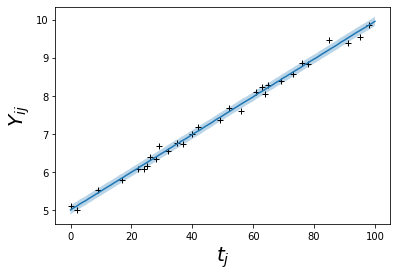

In [69]:
plt.plot(data_sel.day, data_sel.obs, "+", color="black")
plt.plot(x[0:100], np.mean(obs, axis=0))
plt.fill_between(x[0:100], np.mean(obs, axis=0)-np.std(obs, axis=0), np.mean(obs, axis=0)+np.std(obs, axis=0), alpha=0.3)
plt.xlabel(r"$t_j$", fontsize=20)
plt.ylabel(r'$Y_{ij}$', fontsize=20)

In [63]:
np.unique(data[data.myIDs==id_baby]["sigma"].values)

array([0.09647216])

In [64]:
sigma_text = "true sigma: {:.2}".format(np.unique(data[data.myIDs==id_baby]["sigma"].values)[0])

In [65]:
sigma_meas = "meas sigma: {:.3} +/- {:.2}".format(np.mean(sigma), np.std(sigma))

In [66]:
sigma_meas

'meas sigma: 0.204 +/- 0.068'

In [70]:
import arviz as az

In [71]:
data_ana = az.from_numpyro(mcmc)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc96e337490>,
      dtype=object)

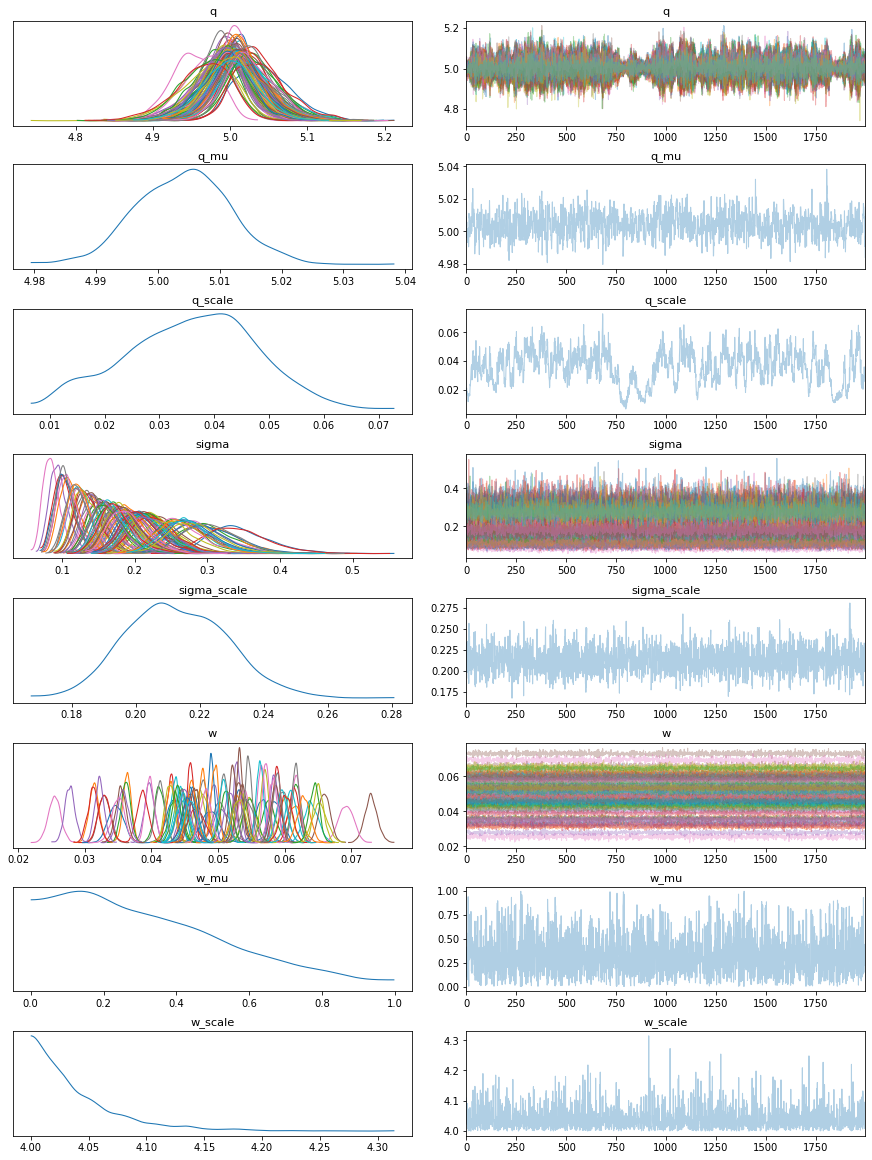

In [72]:
az.plot_trace(data_ana, compact=True)

In [73]:
data_ana

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [60]:
results_points.keys()

dict_keys(['obs', 'q', 'q_mu', 'q_scale', 'sigma', 'sigma_scale', 'w', 'w_mu', 'w_scale'])

In [61]:
results_points["obs"].shape

(2000, 3000)

In [62]:
pull = (np.mean(results_points["obs"], axis=0)-data.obs.values)/(np.std(results_points["obs"], axis=0))

In [63]:
import scipy.stats as stats

Text(0.5, 0, '$\\frac{\\hat{Y}_{ij}-Y_{ij}}{\\sigma_{ij}}$')

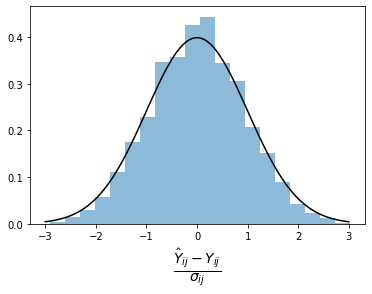

In [68]:
plt.hist(pull, bins=20, density=True, alpha=0.5)
plt.plot(np.linspace(-3., 3., 100), stats.norm.pdf(np.linspace(-3., 3., 100), 0, 1.), color="black")
plt.xlabel(r"$\frac{\hat{Y}_{ij}-Y_{ij}}{\sigma_{ij}}$", fontsize=20)